[0] p: 1.0342 | z: 1.8524 | g_p: 0.5855 | g_z: 50.8060 | params: 0.4978 | loss: 5.6399 | grad_norm: 6.1647
Training test completed!


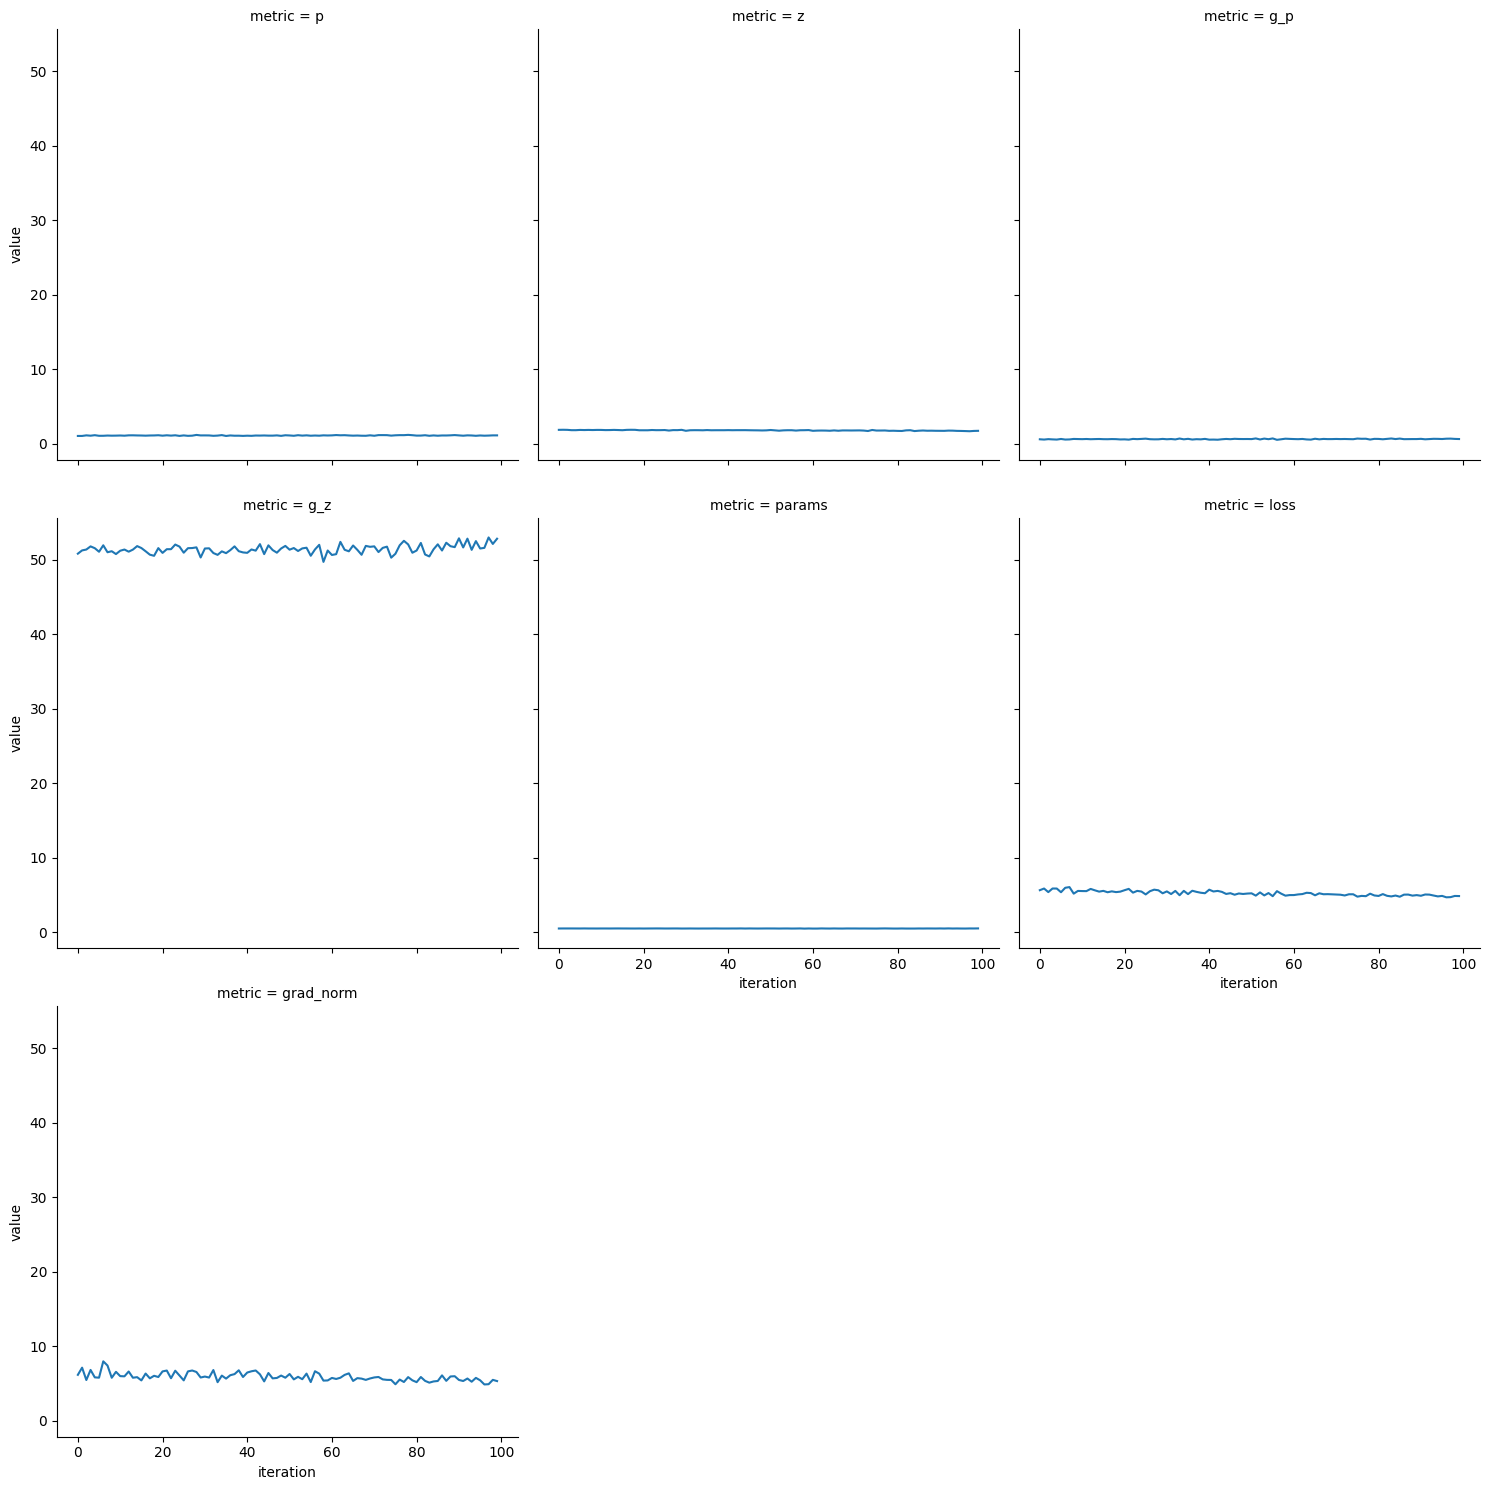

In [ ]:
from collections import defaultdict
import random
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mtp.mheads._abc import AbstractDisributionHeadConfig
from mtp.mheads import MHEADS


def run_train():
    """Test if CP distribution can recover a target distribution on small scale."""
    import torch.optim as optim

    # set seed
    torch.manual_seed(42)
    random.seed(42)

    # Training parameters
    n_iters = 100
    B, R, H, D, V = 32, 2, 4, 128, 100

    config = AbstractDisributionHeadConfig(d_model=D, d_output=V, horizon=H, rank=R)
    mt_head = MHEADS["cp"](config)

    log_dict = defaultdict(list)

    optimizer = optim.AdamW(mt_head.parameters(), lr=1e-3)
    for i in range(n_iters):
        optimizer.zero_grad()

        x = torch.randn(B, D)
        y = torch.randint(0, 2, (B, H)) * (V - 1)
        out = mt_head(x, y)
        out.loss.backward()
        optimizer.step()

        if out.loss_dict is not None:
            for k, v in out.loss_dict.items():
                # Add or create new key if not exists
                if k not in log_dict:
                    log_dict[k] = []
                log_dict[k].append(v)

        # also add grad_norm and loss to log_dict
        log_dict["loss"].append(out.loss.item())
        log_dict["grad_norm"].append(
            torch.nn.utils.clip_grad_norm_(
                mt_head.parameters(), max_norm=float("inf")
            ).item()
        )

        if i % 100 == 0:
            # Print latest values for each metric
            latest_values = {k: v[-1] if v else 0 for k, v in log_dict.items()}
            print(
                f"[{i}] "
                + " | ".join([f"{k}: {v:.4f}" for k, v in latest_values.items()])
            )
            if out.loss.isnan():
                print("Loss is NaN!")
                break

    print("Training test completed!")

    # Plot training metrics using seaborn
    plot_training_metrics(log_dict)


def plot_training_metrics(log_dict):
    """Plot training metrics using seaborn."""
    df = pd.DataFrame(log_dict)
    df["iteration"] = range(len(df))
    sns.relplot(
        data=df.melt(id_vars=["iteration"], var_name="metric", value_name="value"),
        kind="line",
        x="iteration",
        y="value",
        col="metric",
        col_wrap=3
    )
    plt.show()

if __name__ == "__main__":
    run_train()
